In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from functions import *
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# primer parte

In [ ]:
SurfaceSourceFile = kds.SurfaceSourceFile("surface_source.mcpl", domain={"w": [0, 1]})
df = SurfaceSourceFile.get_pandas_dataframe()
del SurfaceSourceFile

In [3]:
# columns_order = ["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]
columns_order = ["x", "y", "ln(E0/E)", "mu"]
# columns_order = ["x","y","ln(E0/E)"]
df = df[columns_order]

In [5]:
micro_bins = [150] * len(columns_order)
# macro_bins = [25] * len(columns_order)
# macro_bins = [15,10,8,6,5,5]
macro_bins = [20, 20, 15, 15]
# macro_bins = [12,12,8,8,5,5]
# macro_bins = [100,100,100]

In [6]:
cumul, micro, macro = calculate_cumulative_histograms(
    df, columns_order, micro_bins, macro_bins, type="equal_area"
)

In [19]:
sampled_df = sample_nd(cumul, micro, macro, columns_order, 4_000_000)

In [ ]:
plot_correlated_variables(sampled_df, columns_order)

In [ ]:
from scipy.stats import entropy
import numpy as np

kl_divergence = entropy(np.histogram(df["x"])[0], np.histogram(sampled_df["x"])[0])
print(kl_divergence)

In [ ]:
from scipy.stats import wasserstein_distance

distance = wasserstein_distance(df["x"], sampled_df["x"])
print(distance)

In [ ]:
corr_original = df.corr(method="pearson")
corr_synthetic = sampled_df.corr(method="pearson")

print(corr_original)
print(corr_synthetic)

# Barrido

Voy a probar barrer diferentes configuraciones y analizar como varian los tiempos y las distancias

In [ ]:
# Datos
columns_order = ["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]
micro_bins = [150] * len(columns_order)
macro_bins = [15, 10, 8, 6, 5, 5]
N = np.logspace(1, 5, 10, base=10, dtype=int)
type = "equal_area"

time_histo = []
time_sample = []

kl_divergence_1d = []
distance = []

for i in range(len(columns_order)):
    kl_divergence_1d.append([columns_order[i]])
    distance.append([columns_order[i]])

for n in N:
    time_histo_batch, time_sample_batch, kl_diverg_aux, distance_aux = testeo(
        "surface_source.mcpl", columns_order, micro_bins, macro_bins, n, type
    )
    time_histo.append(time_histo_batch)
    time_sample.append(time_sample_batch)

    for i in range(len(columns_order)):
        kl_divergence_1d[i].append(kl_diverg_aux[i])
        distance[i].append(distance_aux[i])

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Time for histograms
axes[0, 0].loglog(N, time_histo, label="time_histograms")
axes[0, 0].set_xlabel("Number of samples")
axes[0, 0].set_ylabel("Time [s]")
axes[0, 0].legend()
axes[0, 0].grid()

# Plot 2: Time for sampling
axes[0, 1].loglog(N, time_sample, label="time_sampling")
axes[0, 1].set_xlabel("Number of samples")
axes[0, 1].set_ylabel("Time [s]")
axes[0, 1].legend()
axes[0, 1].grid()

# Plot 3: KL divergence
for kl in kl_divergence_1d:
    axes[1, 0].loglog(N, kl[1:], label="kl_divergence " + kl[0])
axes[1, 0].set_xlabel("Number of samples")
axes[1, 0].set_ylabel("KL divergence")
axes[1, 0].legend()
axes[1, 0].grid()

# Plot 4: Wasserstein distance
for dist in distance:
    axes[1, 1].loglog(N, dist[1:], label="wasserstein_distance " + dist[0])
axes[1, 1].set_xlabel("Number of samples")
axes[1, 1].set_ylabel("Wasserstein distance")
axes[1, 1].legend()
axes[1, 1].grid()

# Add title with information of the run
fig.suptitle(
    "Columns order: "
    + str(columns_order)
    + "\n"
    + "Micro bins: "
    + str(micro_bins)
    + "\n"
    + "Macro bins: "
    + str(macro_bins)
    + "\n"
    + "Type: "
    + type
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
c = [1, 2, 3, 4]
d = c
d.append(5)

print(c + [7])
print(d)

# Prueba con batches

In [21]:
# Data to test
columns_order = ["x", "y", "ln(E0/E)", "mu", "phi"]
micro_bins = [150] * len(columns_order)
macro_bins = [15, 10, 8, 6, 5]
N = np.logspace(4, 6, 8, dtype=int)
batches = 15
type = "equal_bins"

velocidad_estimada = 2.4e6 * 0.71  # samples/min
print("Tiempo estimado total: ", sum(N) * batches / velocidad_estimada, "min")

Tiempo estimado total:  18.16649647887324 min


In [11]:

# Read the surface source file
SurfaceSourceFile = kds.SurfaceSourceFile(
    "../surface_source.mcpl", domain={"w": [0, 1]}
)
df = SurfaceSourceFile.get_pandas_dataframe()
del SurfaceSourceFile
df = df[columns_order + ["wgt"]]

# Calculate the original histogram 1d
# counts_1d_original, edges_1d = []
counts_1d_original, edges_1d = zip(
    *[
        counts_edges
        for counts_edges in [
            np.histogram(df[column], bins=100, weights=df["wgt"])
            for column in columns_order
        ]
    ]
)
counts_1d_original, edges_1d = np.array(counts_1d_original), np.array(edges_1d)
counts_1d_original = np.array([counts / counts.sum() for counts in counts_1d_original])
counts_1d_original[counts_1d_original == 0] = 1e-6

# counts_1d_original, edges_1d = zip(
#     *[
#         (
#             change_zeros(
#                 counts / counts.sum()
#             ),
#             edges
#         )
#         for counts, edges in [
#             np.histogram(df[column], bins=100, weights=df["wgt"])
#             for column in columns_order
#         ]
#     ]
# )

# counts_1d_original, edges_1d = [], []

# for column in columns_order:
#     counts_aux, edges_aux = np.histogram(df[column], bins=100, weights=df["wgt"])
#     counts_aux = counts_aux / sum(counts_aux)
#     change_zeros(counts_aux)
#     counts_1d_original.append(counts_aux)
#     edges_1d.append(edges_aux)
#     del counts_aux, edges_aux

# Calculate the original histogram 2d

counts_2d_original, edges_2d_1, edges_2d_2 = [], [], []

counts_2d_original, edges_2d_1, edges_2d_2 = zip(
    *[
        np.histogram2d(
            df[columns_order[i]], df[columns_order[j]], bins=100, weights=df["wgt"]
        )
        for i in range(len(columns_order) - 1)
        for j in range(i + 1, len(columns_order))
    ]
)

# for i in range(len(columns_order) - 1):
#     for j in range(i + 1, len(columns_order)):
#         counts_2d_original_aux, edges_2d_1_aux, edges_2d_2_aux = np.histogram2d(
#             df[columns_order[i]], df[columns_order[j]], bins=100, weights=df["wgt"]
#         )
#         counts_2d_original.append(counts_2d_original_aux)
#         edges_2d_1.append(edges_2d_1_aux)
#         edges_2d_2.append(edges_2d_2_aux)

# del counts_2d_original_aux, edges_2d_1_aux, edges_2d_2_aux, i, j

counts_2d_original, edges_2d_1, edges_2d_2 = (
    np.array(counts_2d_original),
    np.array(edges_2d_1),
    np.array(edges_2d_2),
)

counts_2d_original = np.array([counts / counts.sum() for counts in counts_2d_original])
counts_2d_original[counts_2d_original == 0] = 1e-6

time_histo = ["Tiempo de calculo de los histogramas"]
# time_histo.append("Tiempo de calculo de los histogramas")
time_sample = ["Tiempo de muestreo"]
# time_sample.append("Tiempo de muestreo")

# Initialize kl_divergence_1d with the name of the columns to later use in the plots
kl_divergence_1d = [[column] for column in columns_order]

# Initialize kl_divergence_2d with the name of the columns to later use in the plots
kl_divergence_2d = [
    [(columns_order[i], columns_order[j])]
    for i in range(len(columns_order) - 1)
    for j in range(i + 1, len(columns_order))
]

Number of particles in file ../surface_source.mcpl: 3514158
100% n, 0% g, 0% e-, 0% e+, 0% p, 


In [ ]:

for n in N:
    print("Number of samples: ", n)

    # Initialize variables to store the results of the batches
    (
        time_histo_container,
        time_sample_container,
        counts_1d_container,
        counts_2d_container,
    ) = (0, 0, np.zeros_like(counts_1d_original), np.zeros_like(counts_2d_original))

    # print(auxiliar)

    # for i in range(len(columns_order)):
    #     counts_1d_container.append([])
    #     for _ in range(len(counts_1d_original[i])):
    #         counts_1d_container[i].append(0)

    # counts_1d_container = np.array(counts_1d_container)
    # print(counts_1d_container)

    # Run the batches
    for batch in range(batches):
        print("Batch: ", batch + 1)

        time_histo_batch, time_sample_batch, counts_1d_batch, counts_2d_batch = (
            get_time_and_counts(
                df,
                columns_order,
                micro_bins,
                macro_bins,
                n,
                edges_1d,
                edges_2d_1,
                edges_2d_2,
                type,
            )
        )
        time_histo_container += time_histo_batch
        time_sample_container += time_sample_batch
        counts_1d_container += counts_1d_batch
        counts_2d_container += counts_2d_batch
        # for i in range(len(counts_1d_original)):
        #     # counts_container[i] += counts_batch[i]
        #     for j in range(len(counts_1d_original[i])):
        #         counts_1d_container[i][j] += counts_1d_batch[i][j]

    # normalize counts_container and take aways the zeros
    counts_1d_container = np.array(
        [counts / counts.sum() for counts in counts_1d_container]
    )
    counts_1d_container[counts_1d_container == 0] = 1e-6

    counts_2d_container = np.array(
        [counts / counts.sum() for counts in counts_2d_container]
    )
    counts_2d_container[counts_2d_container == 0] = 1e-6

    # for i in range(len(counts_1d_container)):
    #     total = sum(counts_1d_container[i])
    #     counts_1d_container[i] = [x / total for x in counts_1d_container[i]]
    #     change_zeros(counts_1d_container[i])

    # plt.figure()
    # plt.stairs(
    #     counts_1d_original[2], edges[2], label="original" + str(sum(counts_1d_original[2]))
    # )
    # plt.stairs(
    #     counts_container[2], edges[2], label="synthetic" + str(sum(counts_container[2]))
    # )
    # plt.legend()
    # plt.show()

    # Calculate the kl divergence
    # for i in range(len(counts_1d_original)):
    #     # if i == 2:
    #     #     test.append(counts_container[i])
    #     kl_divergence_1d[i].append(
    #         sum(rel_entr(counts_1d_original[i], counts_1d_container[i]))
    #     )
    # kl_divergence_1d.append(
    #     [
    #         sum(rel_entr(original, synthetic))
    #         for original, synthetic in zip(counts_1d_original, counts_1d_container)
    #     ]
    # )

    for i, divergence in enumerate(
        [
            sum(rel_entr(original, synthetic))
            for original, synthetic in zip(counts_1d_original, counts_1d_container)
        ]
    ):
        kl_divergence_1d[i].append(divergence)

    # kl_divergence_2d.append(
    #     [
    #         np.sum(rel_entr(original, synthetic))
    #         for original, synthetic in zip(counts_2d_original, counts_2d_container)
    #     ]
    # )

    for i, divergence in enumerate(
        [
            np.sum(rel_entr(original, synthetic))
            for original, synthetic in zip(counts_2d_original, counts_2d_container)
        ]
    ):
        kl_divergence_2d[i].append(divergence)

    # Append the time results
    time_histo.append(time_histo_container)
    time_sample.append(time_sample_container)

# del (
#     batch,
#     batches,
#     counts_1d_batch,
#     counts_1d_container,
#     counts_1d_original,
#     counts_2d_batch,
#     counts_2d_container,
#     counts_2d_original,
#     edges_1d,
#     edges_2d_1,
#     edges_2d_2,
#     i,
#     macro_bins,
#     micro_bins,
#     n,
#     time_histo_batch,
#     time_histo_container,
#     time_sample_batch,
#     time_sample_container, type
# )

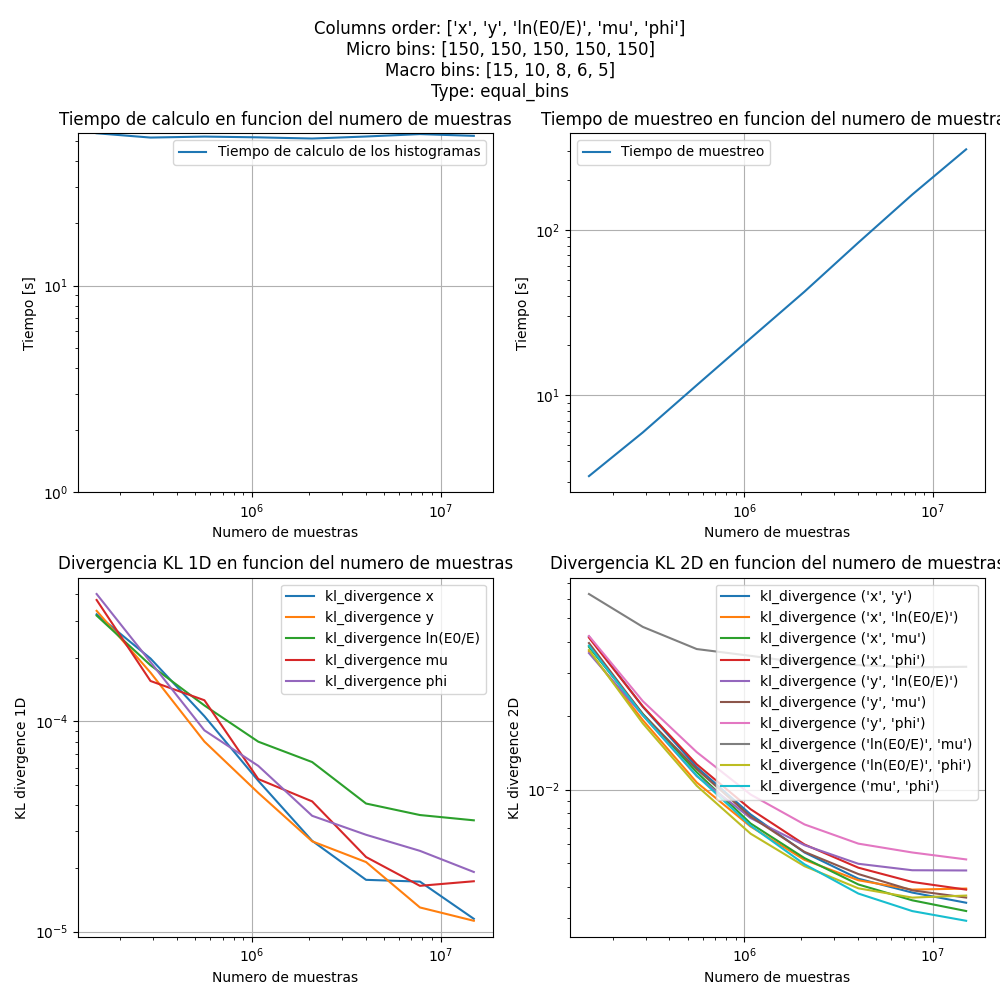

In [13]:
# for n in N:
#     n = n * batches
#     print("Number of samples: ", n)

N = np.array([n * batches for n in N])

# for kl in kl_divergence_1d:
#     for i in range(0, len(kl)-1):
#         kl[i+1] = -kl[i+1]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Time for histograms
axes[0, 0].loglog(N, time_histo[1:], label=time_histo[0])
axes[0, 0].set_xlabel("Numero de muestras")
axes[0, 0].set_ylabel("Tiempo [s]")
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylim(bottom=1)
axes[0, 0].set_title("Tiempo de calculo en funcion del numero de muestras")

# Plot 2: Time for sampling
axes[0, 1].loglog(N, time_sample[1:], label=time_sample[0])
axes[0, 1].set_xlabel("Numero de muestras")
axes[0, 1].set_ylabel("Tiempo [s]")
axes[0, 1].legend()
axes[0, 1].grid()
axes[0, 0].set_ylim(bottom=1)
axes[0, 1].set_title("Tiempo de muestreo en funcion del numero de muestras")

# Plot 3: KL divergence_1d
for kl in kl_divergence_1d:
    axes[1, 0].loglog(N, kl[1:], label="kl_divergence " + kl[0])
axes[1, 0].set_xlabel("Numero de muestras")
axes[1, 0].set_ylabel("KL divergence 1D")
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_title("Divergencia KL 1D en funcion del numero de muestras")

# Plot 4: KL divergence_2d
for kl in kl_divergence_2d:
    axes[1, 1].loglog(N, kl[1:], label="kl_divergence " + str(kl[0]))
axes[1, 1].set_xlabel("Numero de muestras")
axes[1, 1].set_ylabel("KL divergence 2D")
axes[1, 1].legend()
axes[1, 1].grid()
axes[1, 1].set_title("Divergencia KL 2D en funcion del numero de muestras")

# # Plot 4: Wasserstein distance
# for dist in distance:
#     axes[1, 1].loglog(N, dist[1:], label="wasserstein_distance " + dist[0])
# axes[1, 1].set_xlabel("Number of samples")
# axes[1, 1].set_ylabel("Wasserstein distance")
# axes[1, 1].legend()
# axes[1, 1].grid()

# Add title with information of the run
fig.suptitle(
    "Columns order: "
    + str(columns_order)
    + "\n"
    + "Micro bins: "
    + str(micro_bins)
    + "\n"
    + "Macro bins: "
    + str(macro_bins)
    + "\n"
    + "Type: "
    + type
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
import numpy as np

edges_2d_1 = np.linspace(0, 1, 10)
edges_2d_2 = np.logspace(-1, 0, 10)

counts_2d = [
    ((i, j), edges1, edges2)
    for (i, j), edges1, edges2 in zip(
        [(i, j) for i in range(5 - 1) for j in range(i + 1, 5)],
        edges_2d_1,
        edges_2d_2,
    )
]

print(counts_2d)

In [ ]:
a = [[1, 2], [3, 4], [5, 600]]
a = np.array(a)
b = [[1, 2], [7, 8], [9, 10]]
b = np.array(b)
c = rel_entr(b, a)
print(c)
print(np.sum(c))